In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud
import seaborn as sns
import gensim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv1D, MaxPool1D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
data=pd.read_csv('/content/drive/MyDrive/Dataset/withpublicatononly.csv')

In [7]:
data['content'] = data['content'].apply(lambda x: str(x).lower())

In [8]:
data.head()

,Unnamed: 0,content,label
0,0,donald trump sends out embarrassing new year’...,0
1,1,drunk bragging trump staffer started russian ...,0
2,2,sheriff david clarke becomes an internet joke...,0
3,3,trump is so obsessed he even has obama’s name...,0
4,4,pope francis just called out donald trump dur...,0


In [9]:
#Removing special characters
data['content'] = data['content'].astype(str)
data['content'] = data['content'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))


In [10]:
data.head()

,Unnamed: 0,content,label
0,0,donald trump sends out embarrassing new years...,0
1,1,drunk bragging trump staffer started russian ...,0
2,2,sheriff david clarke becomes an internet joke...,0
3,3,trump is so obsessed he even has obamas name ...,0
4,4,pope francis just called out donald trump dur...,0


In [11]:
#Remove stopwords
stop_word = set(stopwords.words('english'))
data['content'] = data['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_word]))

In [12]:
data.head()

,Unnamed: 0,content,label
0,0,donald trump sends embarrassing new years eve ...,0
1,1,drunk bragging trump staffer started russian c...,0
2,2,sheriff david clarke becomes internet joke thr...,0
3,3,trump obsessed even obamas name coded website ...,0
4,4,pope francis called donald trump christmas spe...,0


In [13]:
#lemmatization
lemmatizer = WordNetLemmatizer()
data['content'] = data['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

#shuffle rows
data = data.sample(frac=1)

In [14]:
data.head()

,Unnamed: 0,content,label
25227,25227,democrat say trump agrees work immigration bil...,1
17259,17259,ultimate community organizer neighborhood whit...,0
45648,45648,raven raider thursday red flag warning califor...,0
34464,34464,trump accuses cruz stealing iowa caucus fraud ...,1
11599,11599,wow document show teacher teach history trump ...,0


Word2Vec vectorization

In [15]:
#Convert label into an array. y is a target variable
y = data['label'].values
x = [d.split() for d in data['content'].tolist()]



In [16]:
dim = 300       #dimension of vector after vectorization

w2v_model = gensim.models.Word2Vec(sentences=x, vector_size=dim, window=10, min_count=1)

In [17]:
#Check the no of unique words in vocabulary
len(w2v_model.wv)

220342

In [18]:
#find most similar word
w2v_model.wv.most_similar('nepal')

[('ethiopia', 0.6968832015991211),
 ('nepali', 0.6700421571731567),
 ('restive', 0.6580053567886353),
 ('angola', 0.657054603099823),
 ('nigeria', 0.656842052936554),
 ('sri', 0.6538531184196472),
 ('ababa', 0.623357892036438),
 ('senegal', 0.6222658753395081),
 ('lanka', 0.6149592399597168),
 ('addis', 0.6108184456825256)]

Feed vectors from w2v_model as initial weights to lstm and it again recreates the vector. This improves accuracy

In [19]:
#convert into sequence of texts

tokenizer = Tokenizer()

tokenizer.fit_on_texts(x)       #Assigns unique integer index to each unique word in text

In [20]:
#convert into sequence of numbers
x = tokenizer.texts_to_sequences(x)

In [21]:
#Check sequence for a word
tokenizer.word_index

{'trump': 1,
 'said': 2,
 'u': 3,
 'state': 4,
 'would': 5,
 'president': 6,
 'people': 7,
 'one': 8,
 'republican': 9,
 'year': 10,
 'new': 11,
 'also': 12,
 'say': 13,
 'time': 14,
 'government': 15,
 'house': 16,
 'clinton': 17,
 'reuters': 18,
 'donald': 19,
 'obama': 20,
 'country': 21,
 'could': 22,
 'like': 23,
 'white': 24,
 'united': 25,
 'told': 26,
 'american': 27,
 'election': 28,
 'party': 29,
 'campaign': 30,
 'news': 31,
 'two': 32,
 'last': 33,
 'official': 34,
 'right': 35,
 'first': 36,
 'group': 37,
 'make': 38,
 'week': 39,
 'get': 40,
 'law': 41,
 'even': 42,
 'day': 43,
 'video': 44,
 'former': 45,
 'washington': 46,
 'hillary': 47,
 'many': 48,
 'may': 49,
 'court': 50,
 'want': 51,
 'vote': 52,
 'national': 53,
 'medium': 54,
 'security': 55,
 'woman': 56,
 'police': 57,
 'made': 58,
 'back': 59,
 'image': 60,
 'political': 61,
 'democrat': 62,
 'million': 63,
 'leader': 64,
 'take': 65,
 'bill': 66,
 'going': 67,
 'know': 68,
 'since': 69,
 'way': 70,
 'think':

In [23]:
#calculate news that have more than 1000 words
nos = np.array([len(a) for a in x])
print(len(nos[nos>2000]))

78


In [24]:
max_length = 2000
x = pad_sequences(x, maxlen=max_length)          #padding the sequences #bydefault at the beginning ie "pre"

In [25]:
len(x[0])

2000

In [26]:
#Determine vocabulary size
vocab_size = 160_00
vocab = tokenizer.word_index

In [27]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, dim))

  for word, i in vocab.items():
    if i < weight_matrix.shape[0]:
      weight_matrix[i] = model.wv[word]

  return weight_matrix



In [28]:
embedding_vector = get_weight_matrix(w2v_model)

In [29]:
embedding_vector.shape

(16000, 300)

In [30]:
#Create LSTM model
model = Sequential()
model.add(Embedding(vocab_size, output_dim = dim, weights = [embedding_vector], input_length = max_length, trainable = False ))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = 'accuracy')


In [31]:
model.summary()     #checks the summary of the model    #checks the summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         4800000   
                                                                 
 bidirectional (Bidirection  (None, 128)               186880    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 4987009 (19.02 MB)
Trainable params: 187009 (730.50 KB)
Non-trainable params: 4800000 (18.31 MB)
_________________________________________________________________


In [32]:
#split the data in train and test set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

len(x_train)

39125

In [33]:
history = model.fit(x_train, y_train, validation_split = 0.2, epochs = 40)

Epoch 1/40
979/979 [==============================] - 125s 122ms/step - loss: 0.2618 - accuracy: 0.9006 - val_loss: 0.1524 - val_accuracy: 0.9458
Epoch 2/40
979/979 [==============================] - 127s 130ms/step - loss: 0.1260 - accuracy: 0.9566 - val_loss: 0.1040 - val_accuracy: 0.9640
Epoch 3/40
979/979 [==============================] - 127s 130ms/step - loss: 0.0926 - accuracy: 0.9713 - val_loss: 0.0845 - val_accuracy: 0.9719
Epoch 4/40
979/979 [==============================] - 118s 120ms/step - loss: 0.0856 - accuracy: 0.9726 - val_loss: 0.0869 - val_accuracy: 0.9682
Epoch 5/40
979/979 [==============================] - 127s 130ms/step - loss: 0.0713 - accuracy: 0.9770 - val_loss: 0.0702 - val_accuracy: 0.9771
Epoch 6/40
979/979 [==============================] - 118s 121ms/step - loss: 0.0604 - accuracy: 0.9811 - val_loss: 0.0658 - val_accuracy: 0.9784
Epoch 7/40
979/979 [==============================] - 119s 121ms/step - loss: 0.0539 - accuracy: 0.9818 - val_loss: 0.0545 -

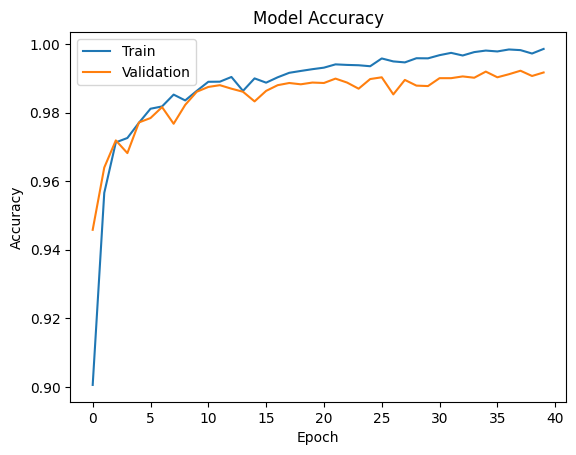

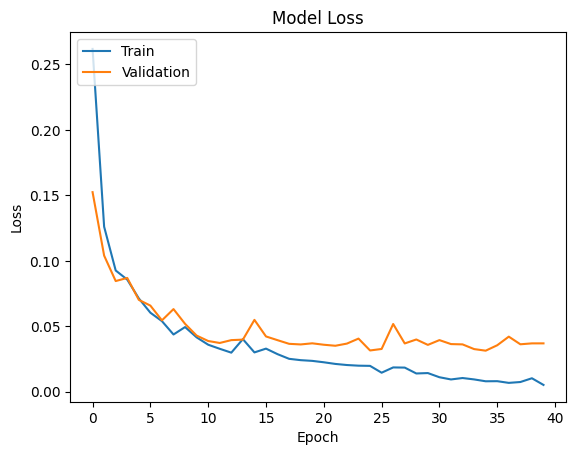

In [34]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
y_pred = (model.predict(x_test)>=0.5).astype(int)

306/306 [==============================] - 15s 47ms/step


In [36]:
accuracy_score(y_test, y_pred)

0.9932529135146186

In [37]:
#Print classification report
print('Classification Report:\n', classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5140
           1       1.00      0.99      0.99      4642

    accuracy                           0.99      9782
   macro avg       0.99      0.99      0.99      9782
weighted avg       0.99      0.99      0.99      9782



In [38]:
model.save("bilstm_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


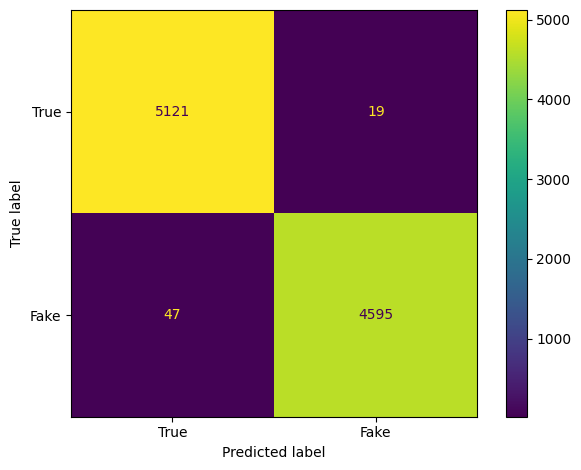

In [39]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix =cm, display_labels =['True', 'Fake'])
cm_display.plot()
plt.tight_layout()
plt.show()

In [40]:
model.save("model_bilstm.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
